In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#export
from lib.nb_03 import *

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

In [4]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

```python 
def untar_data(url:str, fname:PathOrStr=None, dest:PathOrStr=None, data=True, force_download=False) -> Path:
    "Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`."
    dest = url2path(url, data) if dest is None else Path(dest)/url2name(url)
    fname = Path(ifnone(fname, _url2tgz(url, data)))
    if force_download or (fname.exists() and url in _checks and _check_file(fname) != _checks[url]):
        print(f"A new version of the {'dataset' if data else 'model'} is available.")
        if fname.exists(): os.remove(fname)
        if dest.exists(): shutil.rmtree(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, data=data)
        data_dir = Config().data_path()
        if url in _checks:
            assert _check_file(fname) == _checks[url], f"Downloaded file {fname} does not match checksum expected! Remove that file from {data_dir} and try your code again."
        tarfile.open(fname, 'r:gz').extractall(dest.parent)
    return dest
```

In [5]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/Users/vks/.fastai/data/imagenette-160')

### Get Files

We monkey patch the Path class to add the `ls` functionality.

In [6]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [7]:
path.ls()

[PosixPath('/Users/vks/.fastai/data/imagenette-160/train'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val')]

In imagenette we have 10 classes.

In [8]:
(path/'train').ls()

[PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03417042'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03445777'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n02102040'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03425413'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03888257'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03028079'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03000684'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n01440764'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n02979186')]

In [9]:
(path/'val').ls()

[PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n02979186')]

In [10]:
path_tench = (path/'val'/'n03394916')

In [11]:
one_tench = path_tench.ls()[0]

In [12]:
one_tench

PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00046669.JPEG')

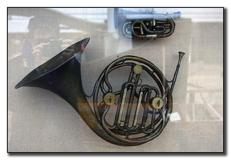

In [13]:
PIL.Image.open(one_tench)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

.

In [14]:
#export
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith("image/"))

get all the files in a directory with a particular extentions.

In [15]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith(".")
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [16]:
path_tench

PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916')

In [17]:
fs = [o.name for o in os.scandir(path_tench)]

In [18]:
fs[:2]

['ILSVRC2012_val_00046669.JPEG', 'ILSVRC2012_val_00033682.JPEG']

```_get_files``` gets us the complete path of the iages in a folder with a specific extensions.

In [19]:
len(fs), _get_files(path_tench, fs, extensions=image_extensions)[:3]

(50,
 [PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00046669.JPEG'),
  PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00033682.JPEG'),
  PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00005548.JPEG')])

In [20]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [21]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [22]:
#export
def get_files(path, extensions=None, recurse=None, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [23]:
get_files(path_tench, extensions=image_extensions)[:3]

[PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00046669.JPEG'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00033682.JPEG'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00005548.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)

In [25]:
len(all_fns)

13394

In [26]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

83.1 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
all_fns[:2]

[PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG')]

In [28]:
all_fns[-2:]

[PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n02979186/ILSVRC2012_val_00042347.JPEG'),
 PosixPath('/Users/vks/.fastai/data/imagenette-160/val/n02979186/ILSVRC2012_val_00042982.JPEG')]

### Preparing for Modelling

What we need to do:

- Get files: `ImageList`
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

In [29]:
#export
class ListContainer():
    
    def __init__(self, items): self.items = listify(items)
    
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                assert len(idx) == len(self.items)
                return [o for o,m in zip(self.items, idx) if m]
            return [self.items[i] for i in idx]
                
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [30]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [31]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [32]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

```python
def compose(x, funcs, *args, order_key="_order", **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x
```

In [33]:
#export
class ItemList(ListContainer):
    
    def __init__(self, items, path=".", tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
        
    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)


In [34]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [35]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

In [36]:
il = ImageList.from_files(path, tfms=MakeRGB())

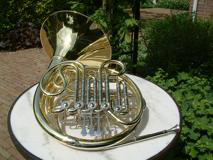

In [37]:
il[2]

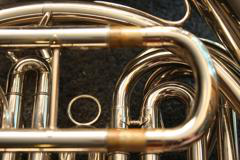

In [38]:
il[0]

In [39]:
il

ImageList (13394 items)
[PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/vks/.fastai/data/imagenette-160

### Split train val

In [40]:
fn = il.items[0]; fn

PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG')

In [41]:
fn.parent.parent

PosixPath('/Users/vks/.fastai/data/imagenette-160/train')

In [42]:
fn.parent.parent.name

'train'

In [43]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [44]:
splitter = partial(grandparent_splitter, valid_name='val')

In [45]:
%time train,valid = split_by_func(il.items, splitter)

CPU times: user 37.2 ms, sys: 1.02 ms, total: 38.2 ms
Wall time: 37.3 ms


In [46]:
len(train),len(valid)

(12894, 500)

In [47]:
type(train)

list

In [48]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [49]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/vks/.fastai/data/imagenette-160
Valid: Ima

### Labelling

Labeling has to be done *after* splitting, because ```it uses *training* set information to apply to the *validation* set, using a *Processor*```.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

In [50]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [75]:
for k,v in enumerate(uniqueify(['a','b','c','c','d'])):
    print(k,v)

0 a
1 b
2 c
3 d


In [51]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [76]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [77]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [78]:
assert ll.train.proc_y is ll.valid.proc_y

In [79]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /Users/vks/.fastai/data/imagenette-160

In [80]:
ll.train.y[0]

0

In [81]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03394916', ['n03394916', 'n03394916'])

In [82]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/vks/.fastai/data/imagenette-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/vks/.fastai/data/imagenette

In [83]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [84]:
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [85]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [86]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

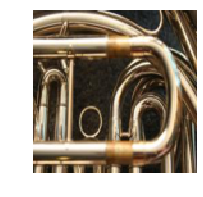

In [87]:
show_image(x)

In [88]:
bs=64

In [89]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [90]:
x,y = next(iter(train_dl))

In [91]:
x.shape

torch.Size([64, 3, 128, 128])

'n03028079'

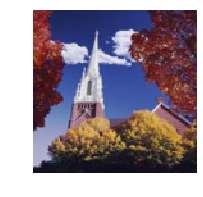

In [92]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [93]:
y

tensor([6, 6, 6, 6, 0, 7, 2, 4, 9, 4, 9, 6, 5, 5, 3, 7, 5, 9, 0, 8, 0, 9, 6, 4,
        7, 5, 9, 7, 4, 2, 3, 1, 1, 1, 7, 3, 8, 1, 1, 9, 1, 3, 9, 3, 2, 3, 3, 5,
        1, 5, 0, 9, 2, 1, 5, 1, 2, 6, 6, 1, 1, 3, 3, 3])

In [94]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [95]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [96]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [97]:
!python notebook2script.py 04_datablock_images.ipynb

Converted 04_datablock_images.ipynb to lib/nb_04.py
